In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Class datareader, this will read and clean the hurricane data. 
- Each unique cyclone has a header that is identified by AL. 
- We then append each cyclone to cyclone_data. Else is saying if the current cyclone doesnt start with AL it is still a part of current cyclone. 

- Returns cyclone_data list, which has ditionaries of specific cyclones by their header and data. 

In [48]:
class DataReader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.all_data = None

    def read_data(self):
        """Reads the cyclone data from a file and initializes the all_data attribute."""
        cyclone_data = []
        current_cyclone = None
        """Taking the headers out and storing them. Always starts with AL if using Atlantic Basin"""
        with open(self.file_path, 'r') as file:
            for line in file:
                if line.startswith('AL'):
                    if current_cyclone is not None:
                        cyclone_data.append(current_cyclone)
                    current_cyclone = {'header': line.strip(), 'data': []}
                else:
                    if current_cyclone is not None:
                        current_cyclone['data'].append(line.strip().split(','))
        if current_cyclone is not None:
            cyclone_data.append(current_cyclone)

        all_cyclone_dfs = []
        """I need to turn this into a dataframe and then add in columns. Columns are based on NHC data ref sheet"""
        for cyclone in cyclone_data:
            df = pd.DataFrame(cyclone['data'], columns=['Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude', 'WindSpeed', 'Pressure',
                                                        'Rad_34_NE', 'Rad_34_SE', 'Rad_34_SW', 'Rad_34_NW', 'Rad_50_NE', 'Rad_50_SE',
                                                        'Rad_50_SW', 'Rad_50_NW', 'Rad_64_NE', 'Rad_64_SE', 'Rad_64_SW', 'Rad_64_NW', 'Rad_maxwnd'])
            
            """I might not have needed to do all of this next part. I am defining each column type. 
                Time block is necessary to make plotting easier later.
                Lat/lon function below referenced here. It takes the letter out allowing for filter later"""
            
            df['Date'] = df['Date'].astype(str)
            df['Time'] = df['Time'].astype(str)
            df['Latitude'] = df['Latitude'].apply(self.convert_lat_lon)
            df['Longitude'] = df['Longitude'].apply(self.convert_lat_lon)
            df['WindSpeed'] = df['WindSpeed'].astype(int)
            df['Pressure'] = df['Pressure'].astype(int)
            df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y%m%d %H%M')
            df.set_index('Datetime', inplace=True)
            df['Cyclone'] = cyclone['header']
            all_cyclone_dfs.append(df)
        self.all_data = pd.concat(all_cyclone_dfs)

    """The static method means we dont need to input a value to use it. In this case it is used above with 
        the given data."""
    @staticmethod
    def convert_lat_lon(value):
        """Converts latitude and longitude to float values."""
        if 'N' in value or 'E' in value:
            return float(value[:-1])
        elif 'S' in value or 'W' in value:
            return -float(value[:-1])

# Class datafilter
- This filters the data with min/max latitude, then min/max longitude. Essentially, you are making a geographical box to say I want any cyclones that were recorded in this box. Get rid of the rest. 

In [49]:
class DataFilter:
    def __init__(self, all_data):
        self.all_data = all_data
        self.filtered_data = None

    def filter_data(self, min_lat, max_lat, min_lon, max_lon):
        """Applies latitude and longitude filters and initializes the filtered_data attribute."""
        self.filtered_data = self.all_data[(self.all_data['Latitude'] >= min_lat) & (self.all_data['Latitude'] <= max_lat) &
                                           (self.all_data['Longitude'] >= min_lon) & (self.all_data['Longitude'] <= max_lon)]
        self.filtered_data['Year'] = self.filtered_data.index.year

# Class cyclone calculator
- Using the previous filter, we now group cyclones by year. This makes plotting very easy.

In [50]:
class CycloneCalculator:
    def __init__(self, filtered_data):
        self.filtered_data = filtered_data
        self.cyclones_per_year = None

    def calculate_cyclones_per_year(self):
        """Groups data by year and counts unique cyclones, initializes the cyclones_per_year attribute."""
        self.cyclones_per_year = self.filtered_data.groupby('Year')['Cyclone'].nunique()
        all_years = pd.Series(0, index=np.arange(self.filtered_data['Year'].min(), self.filtered_data['Year'].max() + 1))
        self.cyclones_per_year = self.cyclones_per_year.reindex(all_years.index, fill_value=0)


# Class Filtered Trend Line Plot
- This will provide a trendline and future projection of 27 years. 
- Instead of linear trend I went with quadratic because it shows better for larger variations.
- 

In [51]:
class FilteredTrendlinePlot:
    def __init__(self, cyclones_per_year):
        self.cyclones_per_year = cyclones_per_year
        self.trendline_values = None
        self.extended_years = None

    def calculate_trendline(self):
        """Calculates the trend line for the data and initializes the trendline_values and extended_years attributes."""
        z = np.polyfit(self.cyclones_per_year.index, self.cyclones_per_year.values, 2)
        p = np.poly1d(z)
        last_year = self.cyclones_per_year.index.max()
        future_years = np.arange(last_year + 1, last_year + 27)
        self.extended_years = np.concatenate((self.cyclones_per_year.index, future_years))
        self.trendline_values = p(self.extended_years)
        

    def plot_cyclone_data(self):
        smoothed_data = self.cyclones_per_year.rolling(window=5).mean()
        """Plots the cyclone data with trend lines and data labels."""
        plt.figure(figsize=(12, 6))
        plt.plot(smoothed_data.index, smoothed_data.values, label='Smoothed Number of Cyclones')
        #plt.bar(self.cyclones_per_year.index, self.cyclones_per_year.values, label='Number of Cyclones')
        plt.plot(self.extended_years, self.trendline_values, "r--", label='Trend Line')

        #for index, value in enumerate(self.cyclones_per_year.values):
        #    plt.text(self.cyclones_per_year.index[index], value, str(value), ha='center', va='bottom')

        plt.title('Area of Interest Total Number of Cyclones per Year with Forecast')
        plt.xlabel('Year')
        plt.ylabel('Number of Cyclones')
        plt.ylim(bottom=0)
        plt.legend()
        plt.grid(True)
        plt.show()

# Class No filter trendline plot
- Does the graph without a filter. Captures all cyclones over time.

In [52]:
class NoFilterTrendlinePlot:
    def __init__(self, all_data):
        self.all_data = all_data
        self.cyclones_per_year = None
        self.trendline_values = None
        self.extended_years = None

    def calculate_cyclones_per_year(self):
        """Groups data by year and counts unique cyclones, initializes the cyclones_per_year attribute."""
        self.all_data['Year'] = self.all_data.index.year
        self.cyclones_per_year = self.all_data.groupby('Year')['Cyclone'].nunique()
        all_years = pd.Series(0, index=np.arange(self.all_data['Year'].min(), self.all_data['Year'].max() + 1))
        self.cyclones_per_year = self.cyclones_per_year.reindex(all_years.index, fill_value=0)

    def calculate_trendline(self):
        """Calculates the trend line for the data and initializes the trendline_values and extended_years attributes."""
        z = np.polyfit(self.cyclones_per_year.index, self.cyclones_per_year.values, 2)
        p = np.poly1d(z)
        last_year = self.cyclones_per_year.index.max()
        future_years = np.arange(last_year + 1, last_year + 27)
        self.extended_years = np.concatenate((self.cyclones_per_year.index, future_years))
        self.trendline_values = p(self.extended_years)

    def plot_cyclone_data(self):
        """Plots the cyclone data with trend lines and data labels."""
        plt.figure(figsize=(12, 6))
        plt.plot(self.cyclones_per_year.index, self.cyclones_per_year.values, marker='o', label='Number of Cyclones')
        plt.plot(self.extended_years, self.trendline_values, "r--", label='Trend Line')

        #for index, value in enumerate(self.cyclones_per_year.values):
        #    plt.text(self.cyclones_per_year.index[index], value, str(value), ha='center', va='bottom')

        plt.title('Atlantic Basin Total Number of Cyclones per Year with Forecast')
        plt.xlabel('Year')
        plt.ylabel('Number of Cyclones')
        plt.ylim(bottom=0)
        plt.legend()
        plt.grid(True)

In [60]:
class BarChartStatusCountNoFilter:

    def __init__(self, all_data):
        self.all_data = all_data
        self.counts_overall = None
        self.status_counts = None

    def status_nofilter(self):
        priority_order = {'HU': 1, 'TS': 2, 'TD': 3}
        self.all_data['StatusPriority'] = self.all_data['Status']
        self.all_data['StatusPriority'].map(priority_order).fillna(4)

        # Sort by Cyclone and StatusPriority
        self.all_data.sort_values(by=['Cyclone', 'StatusPriority'], inplace=True)
        # Extract the first entry for each cyclone based on priority
        self.counts_overall = self.all_data.groupby('Cyclone').first().reset_index()
        self.status_counts = self.counts_overall
        self.status_counts = self.status_counts['StatusPriority'].value_counts()

    @staticmethod
    def add_labels(x, y, ax):
        for i in range(len(x)):
            ax.text(i, y[i], y[i], ha='center',
                 bbox = dict(facecolor = 'white', alpha = .5))

    def plot_with_labels(self):
        if self.status_counts is None:
            raise ValueError("not calculated")
        
        percentage_first_status = self.status_counts.iloc[0] / self.status_counts.sum() * 100
        fig, ax = plt.subplots()
        sns.barplot(x=self.status_counts.index, y=self.status_counts)
        #ax.bar(self.status_counts.index, height=self.status_counts, edgecolor='black')
        ax.set_xlabel('Status of Storm')
        ax.set_ylabel('Count')
        BarChartStatusCountNoFilter.add_labels(self.status_counts.index, self.status_counts, ax)
        ax.set_title('Atlantic Basin Total Count of Storms using Strength')
        ax.text(0.5, 0.9, f"{self.status_counts.index[0]} occurs '{percentage_first_status:.0f}%' of the time",
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax.transAxes,
         fontsize=14)
        ax.text(0.3, 0.8, 'EX = Extratropical(any intensity)\nTD = Tropical Depression <34kts\nTS = Tropical Storm 34-63kts',
                verticalalignment='center',
                transform=ax.transAxes,
                fontsize=12)
        plt.show()

In [61]:
class BarChartFilteredStatus:
    def __init__(self, filtered_data):
        self.filtered_data = filtered_data
        self.filter_counts = None
        self.filter_status_counts = None

    def status_filter(self):
        priority_order = {'HU': 1, 'TS': 2, 'TD': 3}
        self.filtered_data['StatusPriority'] = self.filtered_data['Status']
        self.filtered_data['StatusPriority'].map(priority_order).fillna(4)

        # Sort by Cyclone and StatusPriority
        self.filtered_data.sort_values(by=['Cyclone', 'StatusPriority'], inplace=True)
        # Extract the first entry for each cyclone based on priority
        self.filter_counts = self.filtered_data.groupby('Cyclone').first().reset_index()
        self.filter_status_counts = self.filter_counts
        self.filter_status_counts = self.filter_status_counts['StatusPriority'].value_counts()

    @staticmethod
    def add_labels(x, y, ax):
        for i in range(len(x)):
            ax.text(i, y[i], y[i], ha='center',
                 bbox = dict(facecolor = 'white', alpha = .5))

    def filter_plot_with_labels(self):
        if self.filter_status_counts is None:
            raise ValueError("not calculated")
        
        percentage_first_status = self.filter_status_counts.iloc[0] / self.filter_status_counts.sum() * 100
        fig, ax = plt.subplots()
        sns.barplot(x=self.filter_status_counts.index, y=self.filter_status_counts)
        #ax.bar(self.filter_status_counts.index, height=self.filter_status_counts, edgecolor='black')
        ax.set_xlabel('Status of Storm')
        ax.set_ylabel('Count')
        BarChartFilteredStatus.add_labels(self.filter_status_counts.index, self.filter_status_counts, ax)
        ax.set_title('Area of Interest Total Count of Storms using Strength')
        ax.text(0.5, 0.9, f"{self.filter_status_counts.index[0]} occurs '{percentage_first_status:.0f}%' of the time",
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax.transAxes,
         fontsize=14)
        ax.text(0.3, 0.7, 'TS = Tropical Storm 34-63kts\nHU = Hurricanes >64kts',
                verticalalignment='center',
                transform=ax.transAxes,
                fontsize=13)
        plt.show()

/var/folders/hz/sg34vg_92b77c_hdxw3wkl400000gn/T/ipykernel_17486/969899251.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.filtered_data['Year'] = self.filtered_data.index.year


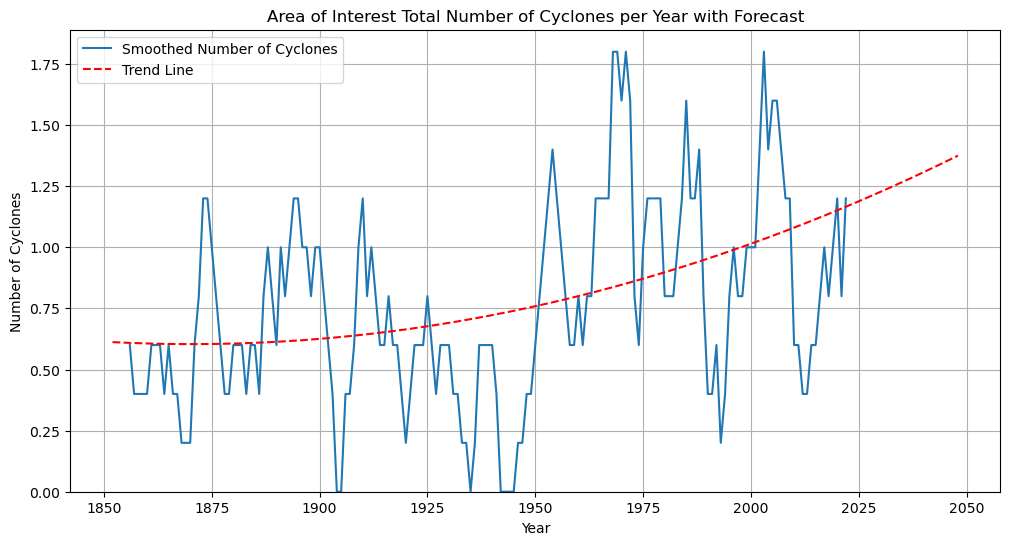

/var/folders/hz/sg34vg_92b77c_hdxw3wkl400000gn/T/ipykernel_17486/1534973441.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, y[i], y[i], ha='center',


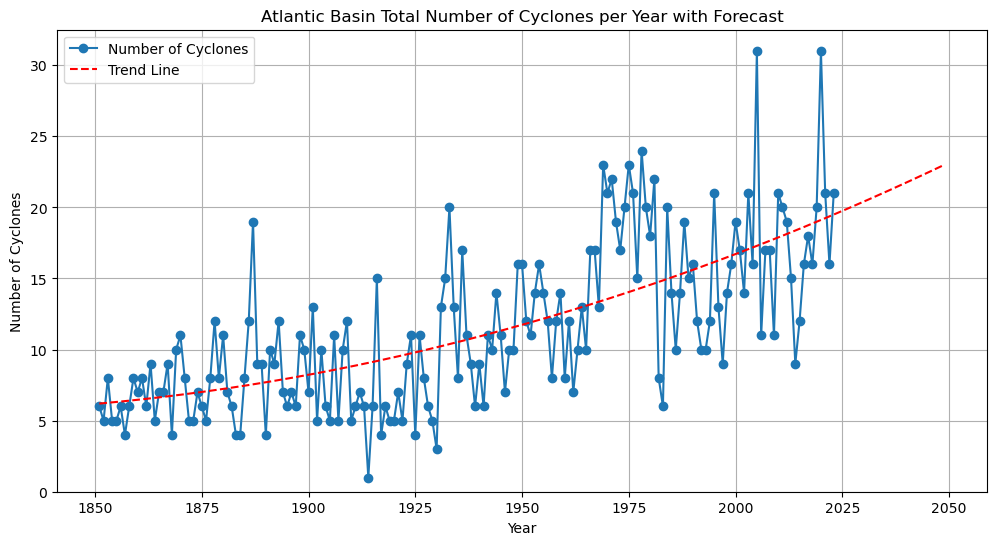

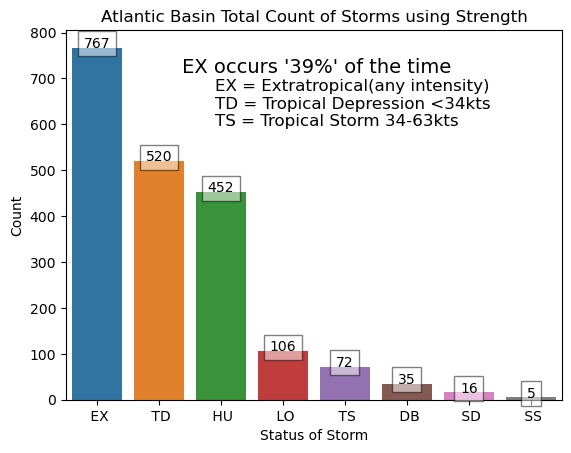

/var/folders/hz/sg34vg_92b77c_hdxw3wkl400000gn/T/ipykernel_17486/3309622042.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.filtered_data['StatusPriority'] = self.filtered_data['Status']
/var/folders/hz/sg34vg_92b77c_hdxw3wkl400000gn/T/ipykernel_17486/3309622042.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.filtered_data.sort_values(by=['Cyclone', 'StatusPriority'], inplace=True)
/var/folders/hz/sg34vg_92b77c_hdxw3wkl400000gn/T/ipykernel_17486/3309622042.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a f

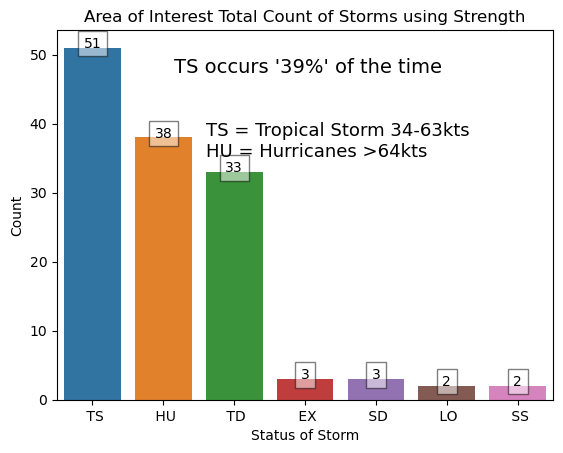

In [62]:
def main():
    file_path = '../data/hurdat2_1851_2023.txt'
    # define the lat/lon of the area you want to hone in on. Coords below are for the AOI. 
    min_lat = 27.5
    max_lat = 29.4
    min_lon = -81.5
    max_lon = -78.8

    # Reading and converting data
    reader = DataReader(file_path)
    reader.read_data()
    
    # Filtering data
    filterer = DataFilter(reader.all_data)
    filterer.filter_data(min_lat, max_lat, min_lon, max_lon)
    
    # Calculating cyclones per year
    calculator_filtered = CycloneCalculator(filterer.filtered_data)
    calculator_filtered.calculate_cyclones_per_year()
    
    # Calculating trendline and plotting data for filtered data
    plotter_filtered = FilteredTrendlinePlot(calculator_filtered.cyclones_per_year)
    plotter_filtered.calculate_trendline()
    plotter_filtered.plot_cyclone_data()

    # Calculating cyclones per year and plotting for unfiltered data
    plotter_unfiltered = NoFilterTrendlinePlot(reader.all_data)
    plotter_unfiltered.calculate_cyclones_per_year()
    plotter_unfiltered.calculate_trendline()
    plotter_unfiltered.plot_cyclone_data()

    # Plot the unfiltered bar chart with labels
    bar_status_count = BarChartStatusCountNoFilter(reader.all_data)
    bar_status_count.status_nofilter()
    bar_status_count.plot_with_labels()

    # Plot the filtered bar chart with labels
    filtered_bar_status = BarChartFilteredStatus(filterer.filtered_data)
    filtered_bar_status.status_filter()
    filtered_bar_status.filter_plot_with_labels()

# Run the main function
main()